# Setup

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
import pickle
import os
import io
import random
import time
import copy
import itertools
from copy import deepcopy
import re
from tqdm import tqdm
import glob
import tikzplotlib
import warnings

import torch
from torch import nn

import numpy as np

import matplotlib.pyplot as plt
from scipy import special  
from scripts.differentiable_pfn_evaluation import eval_model_range, load_model_workflow
import pandas as pd
import seaborn as sns

import model_builder
from model_builder import get_model, get_default_spec, save_model, load_model
import priors
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config

from scripts.model_configs import *
from pathlib import Path

from datasets import load_openml_list, valid_dids_classification, test_dids_classification, valid_large_classification, open_cc_dids, open_cc_valid_dids
from priors.utils import plot_prior, plot_features
from priors.utils import trunc_norm_sampler_f, beta_sampler_f, gamma_sampler_f, uniform_sampler_f, zipf_sampler_f, scaled_beta_sampler_f, uniform_int_sampler_f

from scripts.tabular_metrics import calculate_score_per_method, calculate_score
from scripts.tabular_evaluation import evaluate

from sklearn.metrics import accuracy_score, roc_auc_score
from priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from scripts import tabular_evaluation
from scripts.differentiable_pfn_evaluation import eval_model, evaluate_differentiable_model, eval_model_range
from scripts import tabular_metrics
from notebook_utils import *

In [6]:
large_datasets = True
max_samples = 10000 if large_datasets else 5000
bptt = 10000 if large_datasets else 3000
suite='cc'

In [7]:
device = 'cpu'
base_path = '.'
max_features = 100

In [11]:
def print_models(model_string):
    print(model_string)

    for i in range(80):
        for e in range(50):
            exists = Path(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt')).is_file()
            if exists:
                print(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt'))
        print()

In [10]:
def train_function(config_sample, i, add_name=''):
    start_time = time.time()
    N_epochs_to_save = 50
    
    def save_callback(model, epoch):
        if not hasattr(model, 'last_saved_epoch'):
            model.last_saved_epoch = 0
        if ((time.time() - start_time) / (maximum_runtime * 60 / N_epochs_to_save)) > model.last_saved_epoch:
            print('Saving model..')
            config_sample['epoch_in_training'] = epoch
            save_model(model, base_path, f'models_diff/prior_diff_real_checkpoint{add_name}_n_{i}_epoch_{model.last_saved_epoch}.cpkt',
                           config_sample)
            model.last_saved_epoch = model.last_saved_epoch + 1 # TODO: Rename to checkpoint
    
    model = get_model(config_sample
                      , device
                      , should_train=True
                      , verbose=1
                      , epoch_callback = save_callback)
    
    return

In [288]:
import sklearn

In [289]:
sklearn.__version__

'0.24.2'

# Datasets

In [8]:
cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)
cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)

# Loading longer OpenML Datasets for generalization experiments (optional)
test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)

random.seed(0)
random.shuffle(cc_valid_datasets_multiclass)

Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..
Number of datasets: 150
Loading breast-cancer 13 ..
Loading colic 25 ..
Loading dermatology 35 ..
Loading sonar 40 ..
Loading glass 

In [9]:
def get_datasets(selector, task_type, suite='cc'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = cc_valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

# Fitting a PFN for our prior

## Define prior settings

In [61]:
def get_prior_config(config_type):
    if config_type == 'causal':
        return get_prior_config_causal()
    elif config_type == 'gp':
        return get_prior_config_gp()
    elif config_type == 'bnn':
        return get_prior_config_bnn()
    elif config_type == 'bag_gp_bnn':
        return get_prior_config_bag_gp_bnn()

In [62]:
def get_prior_config_gp():
    config_general = get_general_config(max_features, 50, eval_positions=[30])
    config_general_real_world = {**config_general}

    config_flexible_categorical = get_flexible_categorical_config(max_features)
    config_flexible_categorical_real_world = {**config_flexible_categorical}

    config_gp = {}

    config_diff = get_diff_config()

    config = {**config_general_real_world, **config_flexible_categorical_real_world, **config_diff, **config_gp}
    
    config_sample['differentiable_hyperparameters']['prior_bag_exp_weights_1'] = {'distribution': 'uniform', 'min': 0.0, 'max': .01} # Never select MLP
    

In [63]:
def get_prior_config_bnn():
    config_general = get_general_config(max_features, 50, eval_positions=[30])
    config_general_real_world = {**config_general}

    config_flexible_categorical = get_flexible_categorical_config(max_features)
    config_flexible_categorical_real_world = {**config_flexible_categorical}

    config_gp = {}
    config_mlp = {}

    config_diff = get_diff_config()

    config = {**config_general_real_world, **config_flexible_categorical_real_world, **config_diff, **config_gp, **config_mlp}
    
    config_sample['differentiable_hyperparameters']['prior_bag_exp_weights_1'] = {'distribution': 'uniform', 'min': 1000.0, 'max': 1001.0} # Always select MLP
    

In [66]:
def get_prior_config_causal():
    config_general = get_general_config(max_features, 50, eval_positions=[30])
    config_general_real_world = {**config_general}

    config_flexible_categorical = get_flexible_categorical_config(max_features)
    config_flexible_categorical_real_world = {**config_flexible_categorical}
    config_flexible_categorical_real_world['num_categorical_features_sampler_a'] = -1.0  # Categorical features disabled by default

    config_gp = {}
    config_mlp = {}

    config_diff = get_diff_config()

    config = {**config_general_real_world, **config_flexible_categorical_real_world, **config_diff, **config_gp,
              **config_mlp}
    
    return config

In [67]:
def reload_config(config_type='causal', task_type='multiclass', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'], config['differentiable'], config['flexible'] = 'prior_bag', True, True
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

## Visualize Prior settings

In [70]:
config, model_string = reload_config(longer=1)
config_sample = evaluate_hypers(config)

Using style prior: True
Using cpu:0 device
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 256, 'seq_len': 50, 'seq_len_maximum': 50, 'device': 'cpu:0', 'num_features': 100, 'hyperparameters': {'lr': 0.00018940667637859222, 'dropout': 0.0, 'emsize': 256, 'batch_size': 256, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 50, 'eval_positions': [47], 'seq_len_used': 50, 'sampling': 'normal', 'epochs': 12000, 'num_steps': 100, 'verbose': True, 'pre_sample_causes': True, 'mix_activations': False, 'nan_prob_unknown_reason_reason_prior': 1.0, 'categorical_feature_p': 0.0, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.0, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': <function <lambda>.<locals>.<lambda> at 0x7f76bf755820>, 'noise_type': 'Gaussian', 'balanced': False, 'normalize_to_ranking': False, 'set_value_to_nan': 0.2, 'normalize_by_used_features': True, 'num_features_used

/home/hollmann/anaconda3/envs/prior-fitting/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/hollmann/anaconda3/envs/prior-fitting/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


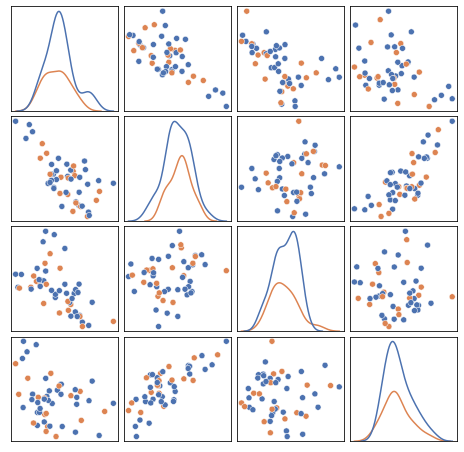

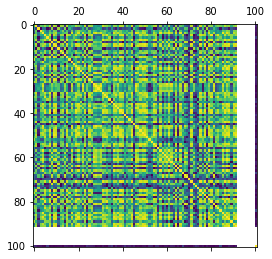

In [73]:
model = get_model(config_sample, device, should_train=False, verbose=2) # , state_dict=model[2].state_dict()
(hp_embedding, data, targets_), targets = next(iter(model[3]))

from utils import normalize_data
fig = plt.figure(figsize=(8, 8))
N = 100
plot_features(normalize_data(data[0:N, 0, 0:4]), targets[0:N, 0], fig=fig)

d = np.concatenate([data[:, 0, :].T, np.expand_dims(targets[:, 0], -1).T])
d[np.isnan(d)] = 0
c = np.corrcoef(d)
plt.matshow(np.abs(c), vmin=0, vmax=1)
plt.show()

## Training

In [ ]:
model = get_model(config_sample, device, should_train=False, verbose=2)

# Prior tuning and inference of a fitted PFN (pretrained model provided)

#### Settings

In [76]:
model_string, longer, task_type = '', 1, 'multiclass'
eval_positions = [1000]
bptt = 2000
    
test_datasets, valid_datasets = get_datasets('test', task_type, suite=suite), get_datasets('valid', task_type, suite=suite)

In [77]:
model_string = ''
i, e = '8x_lr0.0003', -1

# File which contains result of hyperparameter tuning run: style (i.e. hyperparameters) and a dataframe with results.
style_file = 'prior_tuning_result.pkl'

#### Setup helper functions

In [80]:
def load_result(path, i, e, ensemble=0, split_setter=None):
    print(f'loading {path}')
    with open(path, 'rb') as output:
        c, metrics, metrics_valid, style, temperature, optimization_route = CustomUnpickler(output).load()

        metrics = metrics[ensemble]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            for i in range(len(metrics)):
                calculate_score_per_method(tabular_metrics.auc_metric, 'roc', metrics[i], test_datasets, eval_positions)
                calculate_score_per_method(tabular_metrics.cross_entropy, 'cross_entropy', metrics[i], test_datasets, eval_positions)
                calculate_score_per_method(tabular_metrics.time_metric, 'time', metrics[i], test_datasets, eval_positions)
            calculate_score_per_method(tabular_metrics.auc_metric, 'roc', metrics_valid, valid_datasets, eval_positions)
            calculate_score_per_method(tabular_metrics.cross_entropy, 'cross_entropy', metrics_valid, valid_datasets, eval_positions)

        df = {'checkpoint_path': path
              , 'epoch_evaluated': e
              , 'model_id': i}

        hparams = ['dropout', 'multiclass_loss_type', 'aggregate_k_gradients'
                   , 'num_classes_in_training', 'nlayers', 'nhead', 'bptt_in_training', 'lr', 'bptt'
                   , 'batch_size_in_training', 'emsize', 'nan_prob_unknown_reason', 'num_classes_in_training', 'epoch_in_training'
                   , 'normalize_to_ranking', 'categorical_feature_p', 'noise_type', 'set_value_to_nan', 'sampling'
                   , 'mix_activations', 'multiclass_type', 'output_multiclass_ordered_p', 'nan_prob_unknown_reason_reason_prior', 'num_steps']

        df.update({k: c[k] if k in c else None for k in hparams})
        roc, ce, time = [], [], []
        for split in range(0,5):
            time += [metrics[split]['mean_time']]

        if split_setter is None:
            for split in range(0,5):
                roc += [metrics[split]['mean_roc']]
                ce += [metrics[split]['mean_cross_entropy']]
        else:
            roc += [metrics[split_setter]['mean_roc']]
            ce += [metrics[split_setter]['mean_cross_entropy']]
            df['split_setter'] = split_setter
        df['ensemble'] = ensemble
        df.update({'mean_time_test': np.mean(time), 'mean_auc_test': np.mean(roc), 'mean_auc_valid': metrics_valid['mean_roc_at_1000'],
                  'mean_cross_entropy_test': np.mean(ce), 'mean_cross_entropy_valid': metrics_valid['mean_cross_entropy_at_1000']})

        diff_list = DifferentiableHyperparameterList(c['differentiable_hyperparameters'], c['nhid_factor'] * c['emsize'], device)
        diff_hparams_keys, diff_hparams_f = diff_list.get_hyperparameter_info()

        hyper = merge_style_with_info(diff_hparams_keys, diff_hparams_f, style, transform=False)

    return hyper, df, optimization_route, metrics, style, temperature

### Predict using a Fitted and Tuned Model

#### Loading the model

In [78]:
model, c, results_file = load_model_workflow(i, e, add_name=model_string, base_path=base_path, device='cpu', eval_addition='')

Loading models_diff/prior_diff_real_checkpoint_n_8x_lr0.0003_epoch_49.cpkt
Using style prior: True
Using cpu:0 device
Not using distributed
DataLoader.__dict__ {'num_steps': 768, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 1, 'seq_len': 10, 'seq_len_maximum': 10, 'device': 'cpu:0', 'num_features': 100, 'hyperparameters': {'lr': 0.0003, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'normal', 'epochs': 1800, 'num_steps': 768, 'verbose': False, 'pre_sample_causes': True, 'mix_activations': False, 'nan_prob_unknown_reason_reason_prior': 1.0, 'output_multiclass_ordered_p': 0.0, 'categorical_feature_p': 0.1, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.1, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'multiclass_type': 'rank', 'normalize_to_ranking': False, 'set_value_to_

In [81]:
hyper_, df_, optimization_route, metric, style, temperature  = load_result(style_file, i, e)

loading prior_tuning_result.pkl


#### Quick demo: Predict for a given dataset

In [290]:
[(i, test_datasets[i][0]) for i in range(len(test_datasets))]

[(0, 'balance-scale'),
 (1, 'mfeat-fourier'),
 (2, 'breast-w'),
 (3, 'mfeat-karhunen'),
 (4, 'mfeat-morphological'),
 (5, 'mfeat-zernike'),
 (6, 'cmc'),
 (7, 'credit-approval'),
 (8, 'credit-g'),
 (9, 'diabetes'),
 (10, 'tic-tac-toe'),
 (11, 'vehicle'),
 (12, 'eucalyptus'),
 (13, 'analcatdata_authorship'),
 (14, 'analcatdata_dmft'),
 (15, 'pc4'),
 (16, 'pc3'),
 (17, 'kc2'),
 (18, 'pc1'),
 (19, 'banknote-authentication'),
 (20, 'blood-transfusion-service-center'),
 (21, 'ilpd'),
 (22, 'qsar-biodeg'),
 (23, 'wdbc'),
 (24, 'cylinder-bands'),
 (25, 'dresses-sales'),
 (26, 'MiceProtein'),
 (27, 'car'),
 (28, 'steel-plates-fault'),
 (29, 'climate-model-simulation-crashes')]

In [291]:
evaluation_dataset_index = 3 # Index of the dataset to predict
ds = test_datasets[evaluation_dataset_index]
print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape}')

Evaluation dataset name: mfeat-karhunen shape torch.Size([2000, 64])


In [299]:
# This parameter defines the number of inferences to average, the runtime scales almost linearly with N_ensemble_configurations.
# Higher values mostly affect cross entropy. 
N_ensemble_configurations = 10

In [123]:
torch.set_num_threads(1)

eval_xs, eval_ys = ds[1].clone().unsqueeze(1), ds[2].clone().unsqueeze(1)
eval_position = eval_xs.shape[0] // 2

start = time.time()
prediction = transformer_predict(model[2], eval_xs, eval_ys, eval_position,
                        device='cpu',
                        style=style,
                        inference_mode=True,
                                 N_ensemble_configurations=N_ensemble_configurations,
                        softmax_temperature=temperature, **get_params_from_config(c))
prediction_, y_ = prediction.squeeze(0),  eval_ys.squeeze(1).long()[eval_position:]
time_taken = time.time() - start

In [124]:
roc, ce = tabular_metrics.auc_metric(y_, prediction_), tabular_metrics.cross_entropy(y_, prediction_)
roc, ce, time_taken

(tensor(0.9990, dtype=torch.float64), tensor(1.5288), 100.9114248752594)

#### Testing speed
Define as 'ex' your scheduler / execution environment to perform a speed test on (e.g. one cpu kernel, ..) - alternatively remove scheduling.
Code also manually sets torch and libraries to use one kernel. If you wish to use more remove the appropriate code in 'submit_speed_test'.

In [197]:
def submit_speed_test(device, N_ensemble_configurations):
    import os
    os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
    os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
    os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
    os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
    os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
    torch.set_num_threads(1)
    
    result = evaluate(datasets=test_datasets, model=model[2],
                                     method='transformer'
                                     , device=device
                                     , overwrite=True, style=style
                                     , save=False
                                     , path_interfix=''
                                     , metric_used=tabular_metrics.cross_entropy
                                     , return_tensor=False
                                     , verbose=False
                                     , eval_positions=[1000]
                                     , bptt=2000
                                        , inference_mode=True
                                     , softmax_temperature=torch.tensor([0.0]).repeat(3)
                                     , base_path=None
                      , N_ensemble_configurations = N_ensemble_configurations
                    )
    with open(f'speed_results/speed_result_{device}_{N_ensemble_configurations}.pkl', 'wb') as f:
        pickle.dump(result, f)
    
    return result

In [198]:
speed_job_list = []
for device in ['cpu']:
    for ens in [1,5,10,20,50,100]:
        raise Exception("Define ex as your scheduler")
        speed_job_list += [ex.submit(submit_speed_test, device, ens)]

In [ ]:
for device in ['cpu']:
    for ens in [1,5,10,20,50,100]:
        for prep in ['mix', 'robust_all', 'power_all']:     
            speed_result = pickle.load(open(f'speed_results/speed_result_{device}_{ens}_{prep}.pkl',"rb"))
            calculate_score_per_method(tabular_metrics.time_metric, 'time', speed_result, cc_test_datasets_multiclass, [1000])
            print(f'{device}_{ens}_{prep}', speed_result['mean_time'])

#### Printing Prior Hyperparameter tables (optional for reference)

In [277]:
hps_df = pd.DataFrame(hps).T
hps_df.loc[hps_df['choice_values_used'].isna(), 'choice_values_used'] = hps_df[hps_df['choice_values_used'].isna()]['choice_values']
hps_df = hps_df.drop(columns=['choice_values'])
hps_df.loc[hps_df['distribution'] == 'meta_choice_mixed', 'distribution'] = 'meta_choice'

In [278]:
print_table = (hps_df[hps_df['distribution'] == 'uniform'][['min', 'max']].rename(index={'prior_bag_exp_weights_1': 'GP sampling likelihood'})
.rename(columns={'distribution': 'Sampling distribution $p(\psi)$', 'min': 'Minimum', 'max': 'Maximum'}))
print(print_table.to_latex(index=True, escape=False))
print_table = (hps_df[hps_df['distribution'] == 'meta_beta'][['min', 'max', 'scale']].rename(index={'prior_mlp_dropout_prob': 'MLP weight dropout'})
.rename(columns={'distribution': 'Sampling distribution $p(\psi)$', 'min': 'Min $\alpha$ and $\beta$', 'max': 'Max $\alpha$ and $\beta$', 'scale': 'Output scaling'}))
print(print_table.to_latex(index=True, escape=False))
print_table = (hps_df[hps_df['distribution'] == 'meta_choice'][['choice_values_used']].rename(index={'is_causal': 'Sample SCM', 'pre_sample_weights': 'Share Gaussian Noise mean for all nodes', 'y_is_effect': 'Sample y Node in last MLP layer'
                , 'block_wise_dropout': 'Blockwise Dropout', 'sort_features': 'Keep SCM feature order', 'prior_mlp_activations': 'MLP Activation Functions', 'in_clique': 'Sample feature nodes in blocks', 'noise': 'GP noise'})
.rename(columns={'distribution': 'Sampling distribution $p(\psi)$', 'choice_values_used': 'Choices'}))
print(print_table.to_latex(index=True, escape=False))
print_table = (hps_df[hps_df['distribution'] == 'meta_trunc_norm_log_scaled'][['max_mean', 'min_mean', 'round', 'lower_bound']]
 .rename(index={'num_layers': 'MLP \#layers', 'prior_mlp_hidden_dim': 'MLP \#hidden nodes per layer', 'noise_std': 'Gaussian Noise Std.'
                , 'init_std': 'MLP Weights Std.', 'num_causes': 'SCM \#nodes at layer 1', 'outputscale': 'GP outputscale', 'lengthscale': 'GP lengthscale'})
.rename(columns={'distribution': 'Sampling distribution $p(\psi)$', 'max_mean': 'Max Mean', 'min_mean': 'Min Mean', 'round': 'Round value'
                , 'lower_bound': 'Lower bound'}))
print(print_table.to_latex(index=True, escape=False))

\begin{tabular}{lll}
\toprule
{} & Minimum & Maximum \\
\midrule
GP sampling likelihood &     0.5 &     8.0 \\
\bottomrule
\end{tabular}

\begin{tabular}{llll}
\toprule
{} & Min $lpha$ and eta$ & Max $lpha$ and eta$ & Output scaling \\
\midrule
MLP weight dropout &                    0.1 &                    5.0 &            0.9 \\
\bottomrule
\end{tabular}

\begin{tabular}{ll}
\toprule
{} &                                            Choices \\
\midrule
Sample SCM                              &                                      [True, False] \\
Share Gaussian Noise mean for all nodes &                                      [True, False] \\
Sample y Node in last MLP layer         &                                      [True, False] \\
MLP Activation Functions                &  [<class 'torch.nn.modules.activation.Tanh'>, <... \\
Blockwise Dropout                       &                                      [True, False] \\
Keep SCM feature order                  &                   

<>:2: DeprecationWarning: invalid escape sequence \p
<>:5: DeprecationWarning: invalid escape sequence \p
<>:9: DeprecationWarning: invalid escape sequence \p
<>:12: DeprecationWarning: invalid escape sequence \#
<>:12: DeprecationWarning: invalid escape sequence \#
<>:13: DeprecationWarning: invalid escape sequence \#
<>:14: DeprecationWarning: invalid escape sequence \p
<>:2: DeprecationWarning: invalid escape sequence \p
<>:5: DeprecationWarning: invalid escape sequence \p
<>:9: DeprecationWarning: invalid escape sequence \p
<>:12: DeprecationWarning: invalid escape sequence \#
<>:12: DeprecationWarning: invalid escape sequence \#
<>:13: DeprecationWarning: invalid escape sequence \#
<>:14: DeprecationWarning: invalid escape sequence \p
/tmp/ipykernel_1152610/290807830.py:2: DeprecationWarning: invalid escape sequence \p
  .rename(columns={'distribution': 'Sampling distribution $p(\psi)$', 'min': 'Minimum', 'max': 'Maximum'}))
/tmp/ipykernel_1152610/290807830.py:5: DeprecationWarnin

#### Prior tuning and full datasets evaluation
This section runs a differentiable hyperparameter tuning run and saves the results to a results file, which can be inserted in TabularEval.ipynb to compare to other baselines.

In [298]:
# Enabling prior tuning will run differentiable hyperparameter optimization, which is not feasable on CPU.
# If you would like to run on a random configuration to get quick results, disable prior tuning.
enable_prior_tuning = True

In [297]:
eval_positions=[1000]
bptt=2000

N_models = 3
models_per_block = 1

eval_addition = 'user_run'

eval_model(i=i, e=e
      , valid_datasets=cc_valid_datasets_multiclass[90:] if enable_prior_tuning else cc_valid_datasets_multiclass[:1]#valid_datasets[40:] #valid_datasets[40:]
      , test_datasets=cc_test_datasets_multiclass
      , train_datasets=cc_valid_datasets_multiclass[:90] if enable_prior_tuning else cc_valid_datasets_multiclass[:1]
      , eval_positions_valid=[bptt//2]
      , eval_positions_test=[bptt//2]
      , bptt_valid=bptt
      , bptt_test=bptt
      , add_name=model_string
      , base_path=base_path
      , N_draws=5 if enable_prior_tuning else 0
      , N_grad_steps=20 if enable_prior_tuning else 0
      , selection_metric='ce'
      , eval_addition=eval_addition
      , n_parallel_configurations = 3
      , N_ensemble_configurations = 10
      , device=device)

Loading models_diff/prior_diff_real_checkpoint_n_8x_lr0.0003_epoch_49.cpkt
Using style prior: True
Using cpu:0 device
Not using distributed
DataLoader.__dict__ {'num_steps': 768, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 1, 'seq_len': 10, 'seq_len_maximum': 10, 'device': 'cpu:0', 'num_features': 100, 'hyperparameters': {'lr': 0.0003, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'normal', 'epochs': 1800, 'num_steps': 768, 'verbose': False, 'pre_sample_causes': True, 'mix_activations': False, 'nan_prob_unknown_reason_reason_prior': 1.0, 'output_multiclass_ordered_p': 0.0, 'categorical_feature_p': 0.1, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.1, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'multiclass_type': 'rank', 'normalize_to_ranking': False, 'set_value_to_

Iterate over Optimization initializations: 0it [00:00, ?it/s]


Running eval dataset with final params (no gradients)..
tensor([[ 0.1691,  0.7454,  0.3560,  0.1555, -0.2645,  0.5054, -0.2162,  1.3571,
          1.6062, -0.4038,  1.0106,  0.1001,  0.2357,  1.4743, -1.4860, -1.4302,
         -1.6620,  1.1522,  0.9636,  1.2818,  1.6580,  1.0363, -0.1334,  0.9718,
         -1.3223,  0.4847, -1.2355,  1.5404,  0.0757],
        [-1.0744,  0.0392, -0.9550, -1.3931,  1.2547,  1.6382,  1.5964,  1.4083,
          0.9493, -0.5780, -1.4511, -0.3213, -0.9276, -1.2731, -1.5470,  0.7815,
         -1.6925,  0.9373, -1.2230, -1.4566, -1.4217,  0.5960, -0.8821, -0.2753,
          0.1987,  1.2490,  0.7865, -0.7956, -1.2766],
        [-0.1391, -1.5775,  1.0385, -1.4655,  0.0652, -0.6692,  0.2686,  1.5915,
          0.5043, -1.6096, -0.2411,  0.0347,  0.1253,  0.6284, -0.7704, -1.2857,
         -0.3718,  1.5810, -1.0838,  1.3994,  0.1517, -0.1493,  1.3234, -0.1434,
          0.7765, -0.3498,  1.3997,  0.6583,  0.6915]]) tensor([0., 0., 0.])
Running with 1 ensemble_conf

Iterate over datasets:   0%|          | 0/30 [00:09<?, ?it/s]


KeyboardInterrupt: 

#### Plot optimization of a differentiable HP tuning run
Change 'style_file' to your evaluation results path.

In [55]:
hyper_, df_, optimization_route, metric, style, temperature  = load_result(style_file, i, e)

loading prior_tuning_result.pkl


/tmp/ipykernel_1152610/948584267.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='prior_tuning_result.pkl'>
  hyper_, df_, optimization_route, metric, style, temperature  = load_result(style_file, i, e)


In [56]:
from matplotlib.ticker import FormatStrFormatter
renamer = {"loss": "Validation CE Loss", "test_loss": "Training CE Loss"}
for i, optimization_route in enumerate(optimization_routes):
    f, ax = plt.subplots(figsize=(7, 7))
    x, y = 'loss', 'test_loss'
    #x, y = 'select', 'test_select'
    for route in optimization_route:
        route[y], route[x] = np.array(route[y]), np.array(route[x])
        plt.plot(route[x][~np.isnan(route[y])], np.array(route[y][~np.isnan(route[y])]), '-o',  markersize=3)
    ax.set_xlabel(renamer[x])
    ax.set_ylabel(renamer[y])
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

### Model Sequence Length Generalization Experiment

In [300]:
test_datasets_longer_generalization = [ds for ds in test_datasets_multiclass if ds[1].shape[0] >= 10000]

In [301]:
mlp_jobs_eval_longer_list = []

for bptt_ in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]:
    eval_addition = f'model_generalization_to_longer_newest_{bptt_}'
    eval_model(i=i, e=e
      , valid_datasets=test_datasets_longer_generalization[:1]#valid_datasets[40:] #valid_datasets[40:]
      , test_datasets=test_datasets_longer_generalization
      , train_datasets=test_datasets_longer_generalization[:1]
      , eval_positions_valid=[bptt_//2]
      , eval_positions_test=[bptt_//2]
      , bptt_valid=bptt_
      , bptt_test=bptt_
      , add_name=model_string
      , base_path=base_path
      , N_draws=10#30
      , N_grad_steps=20#30
      , selection_metric='ce'
      , eval_addition=eval_addition
      , n_parallel_configurations = 3
      , N_ensemble_configurations = 10
      , device=device)

Loading models_diff/prior_diff_real_checkpoint_n_8x_lr0.0003_epoch_49.cpkt
Using style prior: True
Using cpu:0 device
Not using distributed
DataLoader.__dict__ {'num_steps': 768, 'fuse_x_y': False, 'get_batch_kwargs': {'batch_size': 1, 'seq_len': 10, 'seq_len_maximum': 10, 'device': 'cpu:0', 'num_features': 100, 'hyperparameters': {'lr': 0.0003, 'dropout': 0.0, 'emsize': 512, 'batch_size': 1, 'nlayers': 12, 'num_features': 100, 'nhead': 4, 'nhid_factor': 2, 'bptt': 10, 'eval_positions': [972], 'seq_len_used': 50, 'sampling': 'normal', 'epochs': 1800, 'num_steps': 768, 'verbose': False, 'pre_sample_causes': True, 'mix_activations': False, 'nan_prob_unknown_reason_reason_prior': 1.0, 'output_multiclass_ordered_p': 0.0, 'categorical_feature_p': 0.1, 'nan_prob_no_reason': 0.0, 'nan_prob_unknown_reason': 0.1, 'nan_prob_a_reason': 0.0, 'max_num_classes': 10, 'num_classes': 2, 'noise_type': 'Gaussian', 'balanced': False, 'multiclass_type': 'rank', 'normalize_to_ranking': False, 'set_value_to_

Iterate over Optimization initializations:   0%|          | 0/10 [00:01<?, ?it/s]


KeyboardInterrupt: 

#### Generalization Visualization Code

In [51]:
# Warning this breaks things
eval_addition = 'model_generalization_to_longer_newest_'
test_datasets = test_datasets_longer_generalization
eval_positions = np.array([500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]) // 2
ensembles = [0]

match_string = f'{eval_addition}'
files = [os.path.join(base_path, 'models_diff/', file) for file in files if match_string in file]

NameError: name 'test_datasets_longer_generalization' is not defined

In [1293]:
df = {}
optimization_routes = []
df_hyper = {}
metrics = []
for i, file in enumerate(files):
    for ensemble in ensembles:
        for split_setter in range(0, 5):
            hyper_, df_, optimization_route, metric  = load_result(file, i, e, ensemble=ensemble, split_setter=split_setter)
            df_hyper[file+str(ensemble)+str(split_setter)], df[file+str(ensemble)+str(split_setter)] = hyper_, df_
            optimization_routes += [optimization_route]
            metrics += [metric]
        
df = pd.DataFrame.from_dict(df, orient='index')
df_hyper = pd.DataFrame.from_dict(df_hyper, orient='index')
#df['num_classes_in_training'] = df['num_classes_in_training'].astype(str).str.slice(0, 5)
df

/tmp/ipykernel_443022/3307425477.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_4500.pkl'>
  hyper_, df_, optimization_route, metric  = load_result(file, i, e, ensemble=ensemble, split_setter=split_setter)
/tmp/ipykernel_443022/3307425477.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_4500.pkl'>
  hyper_, df_, optimization_route, metric  = load_result(file, i, e, ensemble=ensemble, split_setter=split_setter)
/tmp/ipykernel_443022/3307425477.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_c

,checkpoint_path,epoch_evaluated,model_id,dropout,multiclass_loss_type,aggregate_k_gradients,num_classes_in_training,nlayers,nhead,bptt_in_training,...,nan_prob_unknown_reason_reason_prior,num_steps,ensemble,mean_time_test,mean_auc_test,mean_auc_valid,mean_cross_entropy_test,mean_cross_entropy_valid,batch_size_effective,split_setter
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_4500.pkl00,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,6.002224,0.778491,NaN,0.790930,NaN,64,NaN
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_4500.pkl01,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,6.002224,0.781297,NaN,0.792994,NaN,64,1.0
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_4500.pkl02,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,6.002224,0.779897,NaN,0.790729,NaN,64,2.0
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_4500.pkl03,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,6.002224,0.777390,NaN,0.789066,NaN,64,3.0
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_4500.pkl04,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,6.002224,0.775381,NaN,0.790932,NaN,64,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_10000.pkl00,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,28.698231,0.790622,NaN,0.778693,NaN,64,NaN
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_10000.pkl01,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,28.698231,0.791781,NaN,0.778138,NaN,64,1.0
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_10000.pkl02,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,28.698231,0.791817,NaN,0.778924,NaN,64,2.0
/work/dlclarge1/hollmann-PFN_Tabular/models_diff/prior_diff_real_results_longer_multiclass_causal_05_02_2022_12_49_44_sams_n_8x_lr0.0003_epoch_44_model_generalization_to_longer_newest_10000.pkl03,/work/dlclarge1/hollmann-PFN_Tabular/models_di...,-1,4,0.0,nono,8,<function <lambda>.<locals>.<lambda> at 0x7fe1...,12,4,1024,...,1.0,768,0,28.698231,0.787148,NaN,0.779340,NaN,64,3.0


In [1298]:
df = df.sort_values('mean_time_test')
df['train_pos'] = np.array([[i,i,i,i,i] for i in eval_positions]).flatten()

In [1305]:
#filehandler = open(f'model_generalization_result.pkl',"wb")
#pickle.dump(df, filehandler)

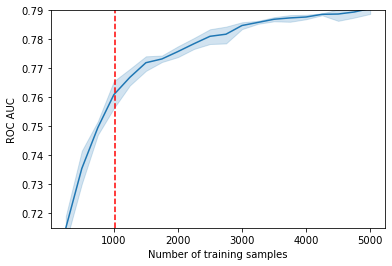

In [1304]:
sns.lineplot(data=df, x='train_pos', y='mean_auc_test')
plt.axvline(x=1024, linestyle='dashed', color='red')
plt.xlabel('Number of training samples')
plt.ylabel('ROC AUC')
plt.ylim((0.715,0.79))
tikzplotlib.save(f'model_generalization.tex', axis_height='6cm', axis_width='6cm')